In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')

In [2]:
from src.experiments import HierPMVAE_v1_Experiment
import torch
from nflows.utils import torchutils
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [23]:
# ckpt_path = "checkpoints/hier_pmvae_v1_1/last_mod.ckpt"
ckpt_path = "checkpoints/hier_pmvae_v1_15/last_mod.ckpt"

# Removing Weights

In [19]:
ckpt = torch.load(ckpt_path)

In [20]:
state_dict = ckpt['state_dict']

In [21]:
del state_dict["linear_probes.0.0.weight"]
del state_dict["linear_probes.0.0.bias"]
del state_dict["linear_probes.1.0.weight"]
del state_dict["linear_probes.1.0.bias"]
del state_dict["linear_probes.2.0.weight"]
del state_dict["linear_probes.2.0.bias"]

In [22]:
torch.save(ckpt, "checkpoints/hier_pmvae_v1_15/last_mod.ckpt")

# Load Model

In [24]:
expt = HierPMVAE_v1_Experiment.load_from_checkpoint(
    checkpoint_path=ckpt_path
)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


# Conditional Sampling

In [25]:
model = expt.model
model.eval();

In [26]:
from nflows.utils import torchutils

In [7]:
posterior = model.s_posterior

In [12]:
B = 5
K = 8

In [25]:
z = torch.randn(5, 32)

In [26]:
z1 = torchutils.merge_leading_dims(
    z.unsqueeze(1).repeat(1, 8, 1),
    num_dims=2
)

In [27]:
z2 = torchutils.repeat_rows(z, 8)

In [29]:
(z1 == z2).all()

tensor(True)

In [27]:
def plot_samples(
    model,
    n_samples=8,
    figsize=8
):
    model.eval();
    s_latent = model.s_prior.sample(1)
    m_latents = [
        torchutils.merge_leading_dims(prior.sample(n_samples, context=s_latent), num_dims=2)
        for prior in model.m_priors
    ]
    mnist, svhn = model.decode({
        "m": m_latents,
        "s": s_latent.repeat(n_samples, 1)
    }, mean=True)

    mnist = F.interpolate(
        mnist, 
        size=(32, 32), 
        mode='bilinear',
        align_corners=False
    )

    mnist_grid = make_grid(mnist, nrow=1)
    svhn_grid = make_grid(svhn, nrow=1)

    grid = torch.cat([mnist_grid, svhn_grid], dim=2).permute(1, 2, 0).detach()

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(grid)

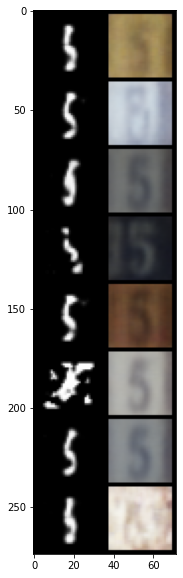

In [43]:
plot_samples(model, figsize=10)

# Try out for PVAE